In [88]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import os
pd.set_option('display.max_columns', None)
pd.set_option('display.precision', 2)
sns.set_style("ticks")
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'retina'
import shutil
from os import listdir
from os.path import join, isfile
#from google.colab import drive
#drive.mount('/content/drive')
#from google.colab import files
! pip install XlsxWriter
import xlsxwriter
from pathlib import Path

In this cell you have to choose a start and end date as well as the countries or region you want to create dashboards for


In [89]:
country_and_region_list=['UNITED KINGDOM', 'FRANCE', 'GREECE', 'HUNGARY', 'IRELAND',
       'ITALY', 'LITHUANIA', 'MEXICO', 'SLOVENIA', 'UKRAINE', 'SPAIN',
       'BRAZIL', 'FINLAND', 'CANADA', 'CHILE', 'TURKEY', 'GERMANY',
       'SWITZERLAND', 'BELGIUM', 'AUSTRIA', 'PERU', 'ARGENTINA',
       'NORTH MACEDONIA', 'COLOMBIA', 'ROMANIA', 'LUXEMBOURG', 'POLAND',
       'COSTA RICA', 'PORTUGAL', 'URUGUAY',"all","Europe","South America"]
#here the regions are Europe, South America and Canada, for the entire euaa region just use "all"
# "rest" here are all countries in Europe excluding 'UNITED KINGDOM','SPAIN','TURKEY',"Italy", and "France"

# choose a start and end date in the following format "year-month-day" with 12 months between them
start_date = "2022-09-01"
end_date = "2023-08-31"
# start_date = "2022-09-01" end_date = "2023-08-31"

# choose all the countries that you want and put them in a list separated by commas

#countries_list=["Europe","South America","all",'SPAIN','UNITED KINGDOM','TURKEY']
countries_list=["all"]



 Very important!!! delete all the already created dashboards in the "finished dashboards" folder


In [90]:
#Define the working directory
dir_path = "./"

#File names for import
all_data = Path(dir_path, "all_data.csv")
revenue_only = Path(dir_path, "revenue_only.csv")
finished_dashboards = Path(dir_path, "finished dashboards")



In [91]:
newer_all=pd.read_csv(all_data)
rev_newer=pd.read_csv(revenue_only)
rev_newer["Date Received"] = pd.to_datetime(rev_newer["Date Received"])
rev_newer =rev_newer.set_index("Date Received")
newer_all["Date Received"] = pd.to_datetime(newer_all["Date Received"])
newer_all =newer_all.set_index("Date Received")

In [92]:
#rest region
filter_list=['GB', 'ES', 'TR','IT','FR']
rev_newer["rest region"]="not in rest"
rev_newer["rest region"][(rev_newer["Reporting Country  ↑"].isin(filter_list)==False)&(rev_newer["adv_Sub_region"]=="Europe")]="rest"
newer_all["rest region"]="not in rest"
newer_all["rest region"][(newer_all["Reporting Country  ↑"].isin(filter_list)==False)&(newer_all["adv_Sub_region"]=="Europe")]="rest"

In [93]:
def count_clinician(num):
  if num > 4:
    return "More than five"
  if num > 1 & num <=4:
    return  "Between 2 to 5 test"
  if num == 1:
    return "One test in three months"

def ordering_freq_input(df,country):
    df=df[df["FOC"]=="Paid"].copy()
    # if no paid tests
    if len (df)==0:
      elf=pd.DataFrame({"Frequency":[],"Freq_Categories":[],"Date":[]})
      elf=elf.groupby(["Date","Freq_Categories"]).sum()

    else:
      times=df["Year_Month"].unique()
      data=[]
      for m in times:
          month=df["Month"][df["Year_Month"]==m].max()
          year=df["Year"][df["Year_Month"]==m].max()
          if month<4:
            start=(f"{year-1}-{12+month-3}-01T00:00:00.000000000")
          else:
            start=(f"{year}-{month-3}-01T00:00:00.000000000")
          tf=df.loc[start:m].copy()
          Interim_df=tf["Contact: Full Name"].value_counts()
          freq_dict = {"Frequency": Interim_df, "Date" : m}
          freq_counts = pd.DataFrame(freq_dict)
          freq_counts["Freq_Categories"] = freq_counts["Frequency"].apply(count_clinician)
          final = freq_counts.groupby(["Date", "Freq_Categories"])["Frequency"].count().reset_index()
          data.append(final)
      freq_plot_df = pd.concat(data)
      elf=freq_plot_df.groupby(["Date","Freq_Categories"]).sum()

    return elf

In [94]:
def set_segments(price):
    if price==0:
        return "0 $"
    elif price<=1500:
        return "0-1500$ "
    elif price<=2000:
        return"1500-2000$ "
    elif price<=3000:
        return"2000-3000$ "
    else:
        return "3000+ $"

rev_newer["price_segment"]= rev_newer["Revenue (USD)"].map(set_segments)

In [95]:
def price_comparison_new_n(df,l_df): #überarbeiten
    year1_df= df[df.index >= df.index.max() - pd.DateOffset(months=12)].copy()
    year2_df= l_df[l_df.index >= year1_df.index.min() - pd.DateOffset(months=12)].copy() #min
    year2_df= year2_df[year2_df.index < year1_df.index.min()].copy()

    year_1=year1_df.groupby("price_segment").sum()
    year_2=year2_df.groupby("price_segment").sum()
    year_1["relshare_1"]=year_1["Sales"]/year_1["Sales"].sum()
    year_2["relshare_2"]=year_2["Sales"]/year_2["Sales"].sum()
    year_1.reset_index(inplace=True)
    year_2.reset_index(inplace=True)
    df_merged = year_1.merge(year_2[["price_segment","relshare_2"]], how='outer', on ="price_segment")
    df_merged["relshare_2"].fillna(0,inplace=True)
    df_merged["relshare_1"].fillna(0,inplace=True)
    df_merged["diff_rel_share"]=round((df_merged["relshare_1"]-df_merged["relshare_2"]),2)
    return df_merged

In [96]:
#old one
def lost_customer_ff(df,df_l,all_,delay,country): #fertig
    df_only_m=all_.copy()
    total=df_l[df_l["FOC"]=="Paid"]

    begin_df=df_only_m[df_only_m.index >=(df.index.max() - pd.DateOffset(months=(13+delay-1)))].copy()# muss hier auch an delay angepasst werden
    final_df=begin_df[begin_df.index <= begin_df.index.min() + pd.DateOffset(months=11)].copy()
    uniq_ms_df=final_df["Year_Month"].unique()
    uniq_ms_df=uniq_ms_df[:12]
    start_list=len(uniq_ms_df)-12
    uniq_ms_df=uniq_ms_df[start_list:]
    lost_customer_counter={}
    for m in uniq_ms_df:
        monthly_loss_counter=0
        all_cus=total["Contact: Full Name"][total["Year_Month"]==m].unique()
        if len(all_cus)>0:
            for c in  all_cus:
                start_m=total[(total["Contact: Full Name"]==c)&(total["Year_Month"]>m)]
                stop=start_m[start_m.index <= start_m.index.min() + pd.DateOffset(months=(delay-1))].copy()
            # delay-1 weil der monat schon größer ist
                add=stop["Sales"][(stop["Contact: Full Name"]==c)].sum() #???
                if add==0:
                    lost_customer_counter[c]=m
                else:
                    lost_customer_counter[f"null {m}"]=m
        else:
            lost_customer_counter[f"null {m}"]=m

    dict_to_df=pd.DataFrame(lost_customer_counter.items())

    dict_to_df["sales"]=0
    dict_to_df["sales"][dict_to_df[0].str.contains("null")==False]=1
    lost_to_list=dict_to_df.copy()
    dict_to_df= dict_to_df.groupby([1,0]).sum()
    lost_customer_export= dict_to_df[dict_to_df["sales"]==1].copy()
    lost_to_list=lost_to_list.groupby([1]).sum()
    return  lost_customer_export,lost_to_list

In [97]:
def lost_customer_newest(df,df_l,all_,delay,country): #fertig
    df_only_m=all_.copy()
    total=df_l[df_l["FOC"]=="Paid"]

    last_month=df["Year_Month"].max()
    date_range = pd.date_range(start='2018-01-01', end='2030-12-01', freq='MS').strftime('%Y-%m-%d')

    time_df = pd.DataFrame({"month":date_range})

    time_df=time_df[time_df["month"]<=last_month]
    # hier von die letzten 18 nehmen
    month_list=time_df["month"].to_list()
    # die letzen 16 und davon die letzten 12 nehmen
    delay_time=-1*(delay+12)
    month_list=month_list[delay_time:]
    month_list=month_list[:12]

    lost_customer_counter={}
    for m in month_list:
        monthly_loss_counter=0
        all_cus=total["Contact: Full Name"][total["Year_Month"]==m].unique()
        if len(all_cus)>0:
            for c in  all_cus:
                start_m=total[(total["Contact: Full Name"]==c)&(total["Year_Month"]>m)]
                stop=start_m[start_m.index <= start_m.index.min() + pd.DateOffset(months=(delay-1))].copy() #???
            # delay-1 weil der monat schon größer ist
                add=stop["Sales"][(stop["Contact: Full Name"]==c)].sum() #???
                if add==0:
                    lost_customer_counter[c]=m
                else:
                    lost_customer_counter[f"null {m}"]=m
        else:
            lost_customer_counter[f"null {m}"]=m

    dict_to_df=pd.DataFrame(lost_customer_counter.items())

    dict_to_df["sales"]=0
    dict_to_df["sales"][dict_to_df[0].str.contains("null")==False]=1
    lost_to_list=dict_to_df.copy()
    dict_to_df= dict_to_df.groupby([1,0]).sum()
    lost_customer_export= dict_to_df[dict_to_df["sales"]==1].copy()
    lost_to_list=lost_to_list.groupby([1]).sum()
    return lost_customer_export,lost_to_list
#lost_customer_newest(tester,abba,abba,6,"uk")

In [98]:
def new_customer_gone_new(df,df_l,all_):
    only_free=df_l[df_l["FOC"]=="Free"]
    df_only_m=all_.copy()
    last_month=df["Year_Month"].max()
    date_range = pd.date_range(start='2018-01-01', end='2025-12-01', freq='MS').strftime('%Y-%m-%d')
    time_df = pd.DataFrame({"month":date_range})
    time_df=time_df[time_df["month"]<=last_month]

    # hier von die letzten 18 nehmen
    month_list=time_df["month"].to_list()
    # die letzen 16 und davon die letzten 12 nehmen
    delay_time=-1*(12)
    month_list=month_list[delay_time:]

    bef_accs=df_l[df_l["FOC"]=="Paid"]
    new_cus_list=[]
    new_cus_list_names={}
    for mo in month_list:
        list_old_accs=bef_accs["Contact: Full Name"][(bef_accs["Year_Month"]<mo)].unique().tolist()
        adder=df["Contact: Full Name"][(df["Year_Month"]==mo)&(df["Contact: Full Name"].isin(list_old_accs)==False)&(df["FOC"]=="Paid")].unique()
        if len(adder)>0:
            for a in adder:
                new_cus_list_names[a]=mo
        else:
            new_cus_list_names[f"null {mo}"]=mo
    new_cus_df=pd.DataFrame(new_cus_list_names.items())
    new_cus_df["Sales"]=0
    new_cus_df["Sales"][new_cus_df[0].str.contains("null")==False]=1
    new_cus_df["Paid"]=0
    new_cus_df["Free"]=0
    free_accounts=only_free["Contact: Full Name"].unique() # wenn account bei den Free, dann auch free
    new_cus_df["Free"][new_cus_df[0].isin(free_accounts)]=1
    new_cus_df["Paid"][new_cus_df[0].isin(free_accounts)==False]=1
    new_cus_df["Paid"]=new_cus_df["Sales"]*new_cus_df["Paid"]
    new_cus_df["Free"]=new_cus_df["Sales"]*new_cus_df["Free"]
    export_new_customer=new_cus_df[new_cus_df[0].str.contains("null")==False].copy()
    export_new_customer=export_new_customer.groupby([1,0]).sum()
    export_new_customer= export_new_customer[["Paid","Free"]]
    new_cus_df=new_cus_df.groupby([1]).sum()
    return export_new_customer,new_cus_df

In [99]:
def win_loss_together(df,df_l,df_total,lag,country):
    export_new,new_customer_df=new_customer_gone_new(df,df_l,df_total)
    export_lost,lost_customer_df=lost_customer_newest(df,df_l,df_total,lag,country) # hier geändert
    new_customer_df.reset_index(inplace=True)
    months_uniq=new_customer_df[1].to_list()
    new_paid=new_customer_df["Paid"].to_list()
    new_free=new_customer_df["Free"].to_list()
# lost customers
    lost_customer_df.reset_index(inplace=True)
    lost_customer_df["sales"]=lost_customer_df["sales"]*-1
    lost_customers=lost_customer_df["sales"].to_list()
    old_vs_new=pd.DataFrame({"time":months_uniq,"only paid test":new_paid,
                         "recieved free test":new_free,"lost_customers":lost_customers})
# difference old and new
    old_vs_new["difference"]=old_vs_new["only paid test"]+old_vs_new["recieved free test"]+old_vs_new["lost_customers"]
    return  old_vs_new ,export_lost, export_new

In [100]:
def final_conversion_rate(df,df_l):
    df_12m=df[df.index >=(df.index.max() - pd.DateOffset(months=(12)))].copy()
    df_12m=df_12m[df_12m.index<=df.index.max()]
    df_prev=df_l[df_l.index >=(df_12m.index.min() - pd.DateOffset(months=(12)))].copy()
    df_prev=df_prev[df_prev.index<df_12m.index.min()]
    free_rec=df_12m["Contact: Full Name"][(df_12m["FOC"]=="Free")].unique()
    prev_buyers=df_prev["Contact: Full Name"][(df_prev["FOC"]=="Paid")].unique()
    new_buyers=df_12m[(df_12m["FOC"]=="Paid")&(df_12m["Contact: Full Name"].isin(free_rec))
                  &(df_12m["Contact: Full Name"].isin(prev_buyers)==False)]
    bigger_df=new_buyers.groupby("Contact: Full Name").sum()
    zero_values=len(free_rec)-len(new_buyers["Contact: Full Name"].unique())
    adder_list=[zero_values]
    d_loop_vals=[1,2,5,10,20]
    for n in d_loop_vals:
        add=(len(bigger_df[bigger_df["Product"]>=n]))
        adder_list.append(add)
    var_names=["0 tests","1 tests","2 tests","5 tests","10 tests","20+ tests"]
    input_df = pd.DataFrame({"absolute_share":adder_list,"group_names":var_names})
    input_df["relshare"]=round(input_df ["absolute_share"]/len(free_rec),2)
    customer_export=bigger_df.copy()
    customer_export=customer_export[["Sales"]]
    return input_df

In [101]:
palette1 = ["#797EF6", "#4ADEDE", "#1AA7EC", "#1E2F97"]
def volume_analysis_4(df,tot,countrie):
    plt.clf()
    sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
    first_date=df.index.astype(str).str[0:7].min()
    last_date=df.index.astype(str).str[0:7].max()
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
#top 2
    rev_plot=df.groupby("Year_Month").sum()
    ef=df.groupby(['Year_Month',"new LIMS Project ID"]).sum()
# bottom 2
    FOC_df=df.groupby(["Year_Month","FOC"]).sum()
    input_data=tot.groupby(["Year_Month","Type"]).sum()
  #00
    sns.set_palette(palette1)


    sns.lineplot(data = input_data, x = "Year_Month", y = "Product", ax=axs[0, 0],hue="Type", linewidth=4,marker="o")
    axs[0,0].tick_params(axis='x', rotation=90)
    axs[0, 0].set_title("Test volume across all segments", fontsize=16,weight=900, y=1.02)
    axs[0, 0].set_ylabel("Amount of test's sold", fontsize=14,weight=700)
    axs[0, 0].set_xlabel("Time in months", fontsize=14,weight=700)
    axs[0, 0].legend(title='Type')

    sns.set_palette(palette1)
    g=sns.lineplot(data=rev_plot,x="Year_Month", y="Revenue (USD)", ax=axs[0, 1]
             ,linewidth=4,marker="o" )
    axs[0,1].tick_params(axis='x', rotation=90)
    axs[0, 1].set_title('Monthly revenue for commercial cases', fontsize=16,weight=900, y=1.02)
    axs[0, 1].set_ylabel("Revenue per month in $", fontsize=14,weight=700)
    axs[0, 1].set_xlabel("Time in months", fontsize=14,weight=700)
    ylabels = ['{:,.0f}'.format(x)+ '$' for x in g.get_yticks()]
    g.set_yticklabels(ylabels)

    sns.set_palette(palette1)
    sns.lineplot(data = ef, x = 'Year_Month', y = "Product",
                     linewidth=4,hue="new LIMS Project ID", ax=axs[1, 0],marker="o" )
    axs[1,0].tick_params(axis='x', rotation=90)
    axs[1, 0].set_title("Commercial volume per product", fontsize=16,weight=900, y=1.02)
    axs[1, 0].set_ylabel("Amount of test's sold", fontsize=14,weight=700)
    axs[1, 0].set_xlabel("Time in months", fontsize=14,weight=700)
    axs[1, 0].legend(title='Product type')

    sns.set_palette(palette1)
    sns.lineplot(data = FOC_df, x = "Year_Month", y = "Product", hue = "FOC"
                     ,linewidth=4, ax=axs[1, 1],marker="o" )
    axs[1,1].tick_params(axis='x', rotation=90)
    axs[1, 1].set_title("Development of paid and free commercial test's ", fontsize=16,weight=900, y=1.02)
    axs[1, 1].set_ylabel("Amount of test's sold", fontsize=14,weight=700)
    axs[1, 1].set_xlabel("Time in months", fontsize=14,weight=700)
    axs[1, 1].legend(title='Paid or free test')


    fig.suptitle(f"Volume metrics for {countrie} between {first_date} and {last_date}",
    fontsize=24, fontweight='bold', y=1.01)
    plt.tight_layout()
    sns.despine()

    images_dir = finished_dashboards
    filename=f"volume_dashboard_{countrie}.pdf"
    plt.savefig(f"{images_dir}/{filename}", dpi = 300,pad_inches = 1, bbox_inches ="tight")

    excel_foc=FOC_df.copy()
    excel_foc.reset_index(inplace=True)
    excel_foc=excel_foc[["Year_Month","FOC","Sales"]]
    excel_product=ef.copy()
    excel_product.reset_index(inplace=True)
    excel_product=excel_product[["Year_Month","new LIMS Project ID","Sales","Revenue(Local_Curr)"]]
    excel_rev=rev_plot.copy()
    excel_rev.reset_index(inplace=True)
    excel_rev=excel_rev[["Year_Month","Sales","Revenue(Local_Curr)","Revenue (USD)"]]
    excel_lims=input_data.copy()
    excel_lims.reset_index(inplace=True)
    excel_lims=excel_lims[["Year_Month","Type","Sales"]]
    return excel_rev, excel_product, excel_foc,excel_lims


In [102]:
def asp_analysis_4(df,total,countrie,):
    plt.clf()
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))#20, 12
    first_date=df.index.astype(str).str[0:7].min()
    last_date=df.index.astype(str).str[0:7].max()

    all_arc=df.groupby("Year_Month").sum()
    all_arc["Arc"]=all_arc["Revenue(Local_Curr)"]/all_arc["Sales"]
    paid_f=df[df["FOC"]=="Paid"].groupby("Year_Month").sum()
    paid_f["Arc"]=paid_f["Revenue(Local_Curr)"]/paid_f["Sales"]

    arc_product=df.groupby(["Year_Month","new LIMS Project ID"]).sum()
    arc_product["Arc"]=arc_product["Revenue(Local_Curr)"]/arc_product["Sales"]
# bottom 2
    seg_input= df[df.index >= df.index.max() - pd.DateOffset(months=12)].copy()
    start=seg_input.index.astype(str).str[0:7].min()
    stop=seg_input.index.astype(str).str[0:7].max()
    total_len = float(len(seg_input))

    df_merged=price_comparison_new_n(df,total)
    x_val=df_merged["price_segment"]
    y_val=df_merged["diff_rel_share"]
    sns.set_palette(palette1)

    sns.lineplot(data = all_arc, x = "Year_Month", y = "Arc",
                     linewidth=4, label="Paid and free",ax=axs[0,0],marker="o" )
    a=sns.lineplot(data = paid_f, x = "Year_Month", y = "Arc",color="steelblue",
                     linewidth=4, label="Only paid",ax=axs[0,0],marker="o" )
    axs[0,0].tick_params(axis='x', rotation=90)
    axs[0, 0].set_title("Asp for commercial tests", fontsize=16,weight=900)
    axs[0, 0].set_ylabel("Asp in local currency",weight=700, fontsize=14)
    axs[0, 0].set_xlabel("Time in months",weight=700, fontsize=14)
    axs[0, 0].legend(title='Asp types')
# arc per product------------------------------------
    sns.set_palette(palette1)

    b= sns.lineplot(data = arc_product, x = "Year_Month", y = "Arc",
                     linewidth=4,hue="new LIMS Project ID",ax=axs[0,1],marker="o"
                    )#,palette="Set1"
    axs[0,1].tick_params(axis='x', rotation=90)
    axs[0, 1].set_title('Asp per product', fontsize=16,weight=900)
    axs[0, 1].set_ylabel("Asp in local currency",weight=700, fontsize=14)
    axs[0, 1].set_xlabel("Time in months",weight=700, fontsize=14)
    axs[0, 1].legend(title='Product type')

# price segments -----------------------
    pre_order=["0 $","0-1500$ ","1500-2000$ ","2000-3000$ ","3000+ $",]

    c=sns.countplot(data =seg_input
            ,x ="price_segment",order=pre_order, ax=axs[1, 0], edgecolor='black',palette="Blues_r")
    for p in axs[1, 0].patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_len) # Percentage of each bar
        axs[1, 0].annotate(percentage, (p.get_x()+0.3, p.get_height()),fontsize=14,weight=800)
    axs[1, 0].set_title(f"Commercial price segments in the last 12 month's ", fontsize=16,weight=900)
    axs[1, 0].set_ylabel("Amount of test's sold",weight=700, fontsize=14)
    axs[1, 0].set_xlabel("Price segments",weight=700, fontsize=14)

# price segment comparison -------------------------------------
    palette = {1: 'green', -1: 'red', 0: 'gray'}
    y_sign = np.sign(y_val)
    d=sns.barplot(x=x_val, y=y_val, palette=palette, hue=y_sign,dodge=False, edgecolor='black',
    linewidth=1.5, ax=axs[1, 1])
    for p in axs[1, 1].patches:
        axs[1, 1].annotate('{:.2f}%'.format(p.get_height()*100), ((p.get_x()) + p.get_width() / 2, p.get_height()),
    ha='center', va='center', fontsize=11, color='black',weight=800, xytext=(0, 10),
                textcoords='offset points')
    axs[1, 1].axhline(y=0, color='black', linewidth=1.5)
    ylabels = ['{:,.2f}'.format(x*100) + '%' for x in d.get_yticks()]
    d.set_yticklabels(ylabels)
    axs[1, 1].set_title(f"Difference in price segments between the last 12 and 12-24 months", fontsize=16,weight=1000)
    axs[1, 1].set_ylabel("Change in relative share per segment",weight=700, fontsize=14)
    axs[1, 1].set_xlabel("Price segments",weight=700, fontsize=14)
    axs[1, 1].legend().set_visible(False)

    fig.suptitle(f"Asp analysis for {countrie} between {first_date} and {last_date}:",
             fontsize=24, fontweight='bold', y=1.01,)
    plt.tight_layout()#pad=1, w_pad=0.7, h_pad=3.0
    sns.despine()
    images_dir = finished_dashboards
    filename=f"ASP analysis_dashboard_{countrie}.pdf"
    plt.savefig(f"{images_dir}/{filename}", dpi = 300,pad_inches = 1, bbox_inches ="tight")


    #excel export
    arc_total=all_arc.copy()
    arc_total.reset_index(inplace=True)
    arc_total=arc_total[["Year_Month","Arc","Sales","Revenue(Local_Curr)","Revenue (USD)"]]
    arc_paid_e=paid_f.copy()
    arc_paid_e.reset_index(inplace=True)
    arc_paid_e=arc_paid_e[["Year_Month","Arc","Sales","Revenue(Local_Curr)","Revenue (USD)"]]
    return arc_total,arc_paid_e

In [103]:
def customer_analysis_4(df,l_df,all_t,amount,countrie):
    plt.clf()
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(24, 14))#20, 12
    first_dates=df.index.astype(str).str[0:7].min()
    last_dates=df.index.astype(str).str[0:7].max()
# top 10 customers
    df_paid=df[df["FOC"]=="Paid"].copy()

    # in case their are 0 cases:
    if len(df_paid)==0:
      top_x=pd.DataFrame({"Account: Account Name":["no accounts"],"Product":[0]})
      rel_share=0

    else:
      df_paid=df_paid[df_paid.index >=(df.index.max() - pd.DateOffset(months=(12)))].copy()
      df_paid=df_paid[df_paid.index<=df.index.max()]
      top_x=df_paid.groupby(["Account: Account Name"]).sum().sort_values("Product",ascending=False)
      top_x.sort_values("Product")
      top_x=top_x[:amount]
      rel_share=round(top_x["Product"].sum()/len(df_paid),2)
      top_x.reset_index(inplace=True)
# ordering freq-----------------------
    order_freq_input=ordering_freq_input(df,countrie)

# conversion rate
    input_wll=final_conversion_rate(df,l_df)
# customer win/loss
    graf_plot,lost,new=win_loss_together(df,l_df,all_t,6,countrie)
# Plotting
    a=sns.barplot(data=top_x,x="Product",y="Account: Account Name",palette="Blues_r",
              ax=axs[0,0],orient='h', edgecolor='black')

    color_diff=["#0d88e6", "#4421af", "#1a53ff"]
    b=sns.lineplot(data=order_freq_input,x="Date",y="Frequency",hue="Freq_Categories",
           linewidth=4,palette= "Set1",ax=axs[0,1],marker="o" )

#conversion rate------------------
    col_palette=["red",'#104a8e',"#1357a6","#1663be","#1870d5","#1870d6"]
    c=sns.barplot(data=input_wll, x="group_names",y="relshare",palette=   col_palette,ax=axs[1,0]
             , edgecolor='black')
    ylabelss = ['{:,.0f}'.format(x*100)+ '%' for x in c.get_yticks()]
    c.set_yticklabels(ylabelss)
    for p in axs[1, 0].patches:
        axs[1, 0].annotate('{:.0f}%'.format(p.get_height()*100), (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='center', fontsize=11, color='black', xytext=(0, 10),
                textcoords='offset points')

#w/l---------------------------------------------
    color=colors_c=["green","orange","red"]
   # winner=graf_plot[["time","new_paid","new_free","lost_customers"]]
    winner=graf_plot[["time","only paid test","recieved free test","lost_customers"]]

    d=winner.plot(kind = 'bar', stacked = True,x="time",
         edgecolor='black',linewidth=2,color=colors_c,ax=axs[1,1])

    sns.lineplot(data=graf_plot,x="time",y="difference",color="black",linewidth=3
            , label="Difference new and old customers",marker="o",ax=axs[1,1])
    axs[1, 1].axhline(y=0, color='black', linewidth=2)

    d.bar_label(d.containers[0],fontsize=13, weight="bold")
    d.bar_label(d.containers[1],fontsize=13, weight="bold")
    d.bar_label(d.containers[2],fontsize=13, weight="bold")

    #e.bar_label(e.containers[1],fontsize=13, weight="bold")

    axs[0,1].tick_params(axis='x', rotation=90)
    axs[1,1].tick_params(axis='x', rotation=90)

    axs[0, 0].set_title(f"Top {amount} accounts in the last 12 months made up {round(rel_share*100,)}% of all paid commercial sales in {countrie}", fontsize=16,weight=900)
    axs[0, 0].set_ylabel("")

    axs[0, 0].set_xlabel("Sales per account",weight=700, fontsize=14)
    axs[0, 1].set_title('Ordering frequency of paid commercial tests in the last 3 months', fontsize=16,weight=900)
    axs[0, 1].set_ylabel("Amount of customers",weight=700, fontsize=14)
    axs[0, 1].set_xlabel("Time in months",weight=700, fontsize=14)
    axs[1, 0].set_title(f"Conversion rate after recieving a free commercial test in the last 12 months", fontsize=16,weight=900)
    axs[1, 0].set_ylabel("Relative share ",weight=700, fontsize=14)
    axs[1, 0].set_xlabel("Order segments per customer",weight=700, fontsize=14)
    axs[1, 1].set_title(f"Customer win/ loss after buying a paid commercial test ", fontsize=16,weight=1000)
    axs[1, 1].set_ylabel("Amount of customers gained or lost",weight=700, fontsize=14)
    axs[1, 1].set_xlabel("Time in months",weight=700, fontsize=14)
    axs[0, 1].legend(title='Frequency segments')

    fig.suptitle(f"Customer analysis for {countrie} between {first_dates} and {last_dates}",
             fontsize=24, fontweight='bold', y=1.01)
    plt.tight_layout()#pad=1, w_pad=0.7, h_pad=3.0
    sns.despine()
    images_dir = finished_dashboards
    filename=f"customer_analysis_dashboard_{countrie}.pdf"
    plt.savefig(f"{images_dir}/{filename}", dpi = 300,pad_inches = 1, bbox_inches ="tight")

#excel abspeichern
    lost_cus=lost.copy()
    lost_cus.reset_index(inplace=True)
    new_cus=new.copy()
    new_cus.reset_index(inplace=True)
    return new_cus,lost_cus

In [104]:
def create_all_plots_r(revenue,all_cases,countries,start_date,end_date):
    rev_time=revenue.loc[start_date:end_date].copy()
    all_time= all_cases.loc[start_date:end_date].copy()
    longer_df=revenue.copy()
    for t_country in countries:
        if  t_country !="all"and t_country !="rest" and len(revenue[revenue["adv_Sub_region"]==t_country])==0:
            rev_t=rev_time[rev_time["Reporting Country"]== t_country].copy()
            all_t=all_time[all_time["Reporting Country"]== t_country].copy()
            rev_all=longer_df[longer_df["Reporting Country"]==t_country].copy()
            con_title=t_country.title()
        elif t_country !="rest" and  t_country !="all" and len(revenue[revenue["adv_Sub_region"]==t_country])>0:
            rev_t=rev_time[rev_time["adv_Sub_region"]== t_country].copy()
            all_t=all_time[all_time["adv_Sub_region"]== t_country].copy()
            rev_all=longer_df[longer_df["adv_Sub_region"]==t_country].copy()
            con_title=t_country.title()
        elif len(revenue[revenue["rest region"]==t_country])>0 and t_country !="all":
          rev_t=rev_time[rev_time["rest region"]== t_country].copy()
          all_t=all_time[all_time["rest region"]== t_country].copy()
          rev_all=longer_df[longer_df["rest region"]==t_country].copy()
          con_title=t_country.title()
        else:
            rev_t=rev_time.copy()
            all_t=all_time.copy()
            rev_all=longer_df.copy()
            con_title="all Euaa countries"
        # nach regionen ändern

        excel_rev, excel_product, excel_foc,excel_lims_id=volume_analysis_4( rev_t,all_t,con_title)
        arc_total,arc_paid_e =asp_analysis_4(rev_t,rev_all,con_title)
        new_cus_excel, lost_cus_excel=customer_analysis_4(rev_t,rev_all,rev_all,10,con_title)

    # save to excel
        excel_dir = finished_dashboards
        filename=f"revenue_dashboard_{con_title}.xlsx"
        writer = pd.ExcelWriter(f"{excel_dir}/{filename}", engine='xlsxwriter')
        excel_rev.to_excel(writer, sheet_name='Monthly revenue')
        excel_product.to_excel(writer, sheet_name='Revenue devided by product')
        excel_foc.to_excel(writer, sheet_name='FOC')
        excel_lims_id.to_excel(writer, sheet_name='Type')
        arc_total.to_excel(writer, sheet_name='Arc paid and free tests')
        arc_paid_e.to_excel(writer, sheet_name='Arc only paid tests')
        new_cus_excel.to_excel(writer, sheet_name='New customers')
        lost_cus_excel.to_excel(writer, sheet_name='Lost customers')
        worksheet_1 = writer.sheets['Monthly revenue']#
        worksheet_1.set_zoom(90)
        worksheet_1.set_column('A:F', 20)
        worksheet_2 = writer.sheets['Revenue devided by product']#
        worksheet_2.set_zoom(90)
        worksheet_2.set_column('A:F', 20)
        worksheet_3 = writer.sheets['FOC']#
        worksheet_3.set_zoom(90)
        worksheet_3.set_column('A:F', 20)
        worksheet_4 = writer.sheets['Arc paid and free tests']#
        worksheet_4.set_zoom(90)
        worksheet_4.set_column('A:F', 20)
        worksheet_5 = writer.sheets['Arc only paid tests']
        worksheet_5.set_zoom(90)
        worksheet_5.set_column('A:F', 20)
        worksheet_6 = writer.sheets['New customers']
        worksheet_6.set_zoom(90)
        worksheet_6.set_column('A:F', 20)
        worksheet_7 = writer.sheets['Lost customers']
        worksheet_7.set_zoom(90)
        worksheet_7.set_column('A:F', 20)
        worksheet_8 = writer.sheets['Type']
        worksheet_8.set_zoom(90)
        worksheet_8.set_column('A:F', 20)
        writer.save()

In [105]:
os.getcwd()

'/Users/mhausch/Data/GH_Dashboards'

In [106]:
def file_sorter(countries_to_sort):
    mypath='./finished dashboards'
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    for i in countries_to_sort:
        folder_name="/"+i+"_all_plots"
        target_file= mypath+folder_name
        for file in onlyfiles:
            if i in file:
                shutil.move(file,target_file)
            else:
                pass

In [107]:
def file_sorter(countries_to_sort):
    mypath=finished_dashboards
    onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    for i in countries_to_sort:
        folder_name="/"+i+"_all_plots"
        target_file= mypath+folder_name
        for file in onlyfiles:
            if i in file:
                shutil.move(file,target_file)
            else:
                pass

In [108]:
type(finished_dashboards)


pathlib.PosixPath

AttributeError: 'XlsxWriter' object has no attribute 'save'

<Figure size 640x480 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

<Figure size 2000x1200 with 0 Axes>

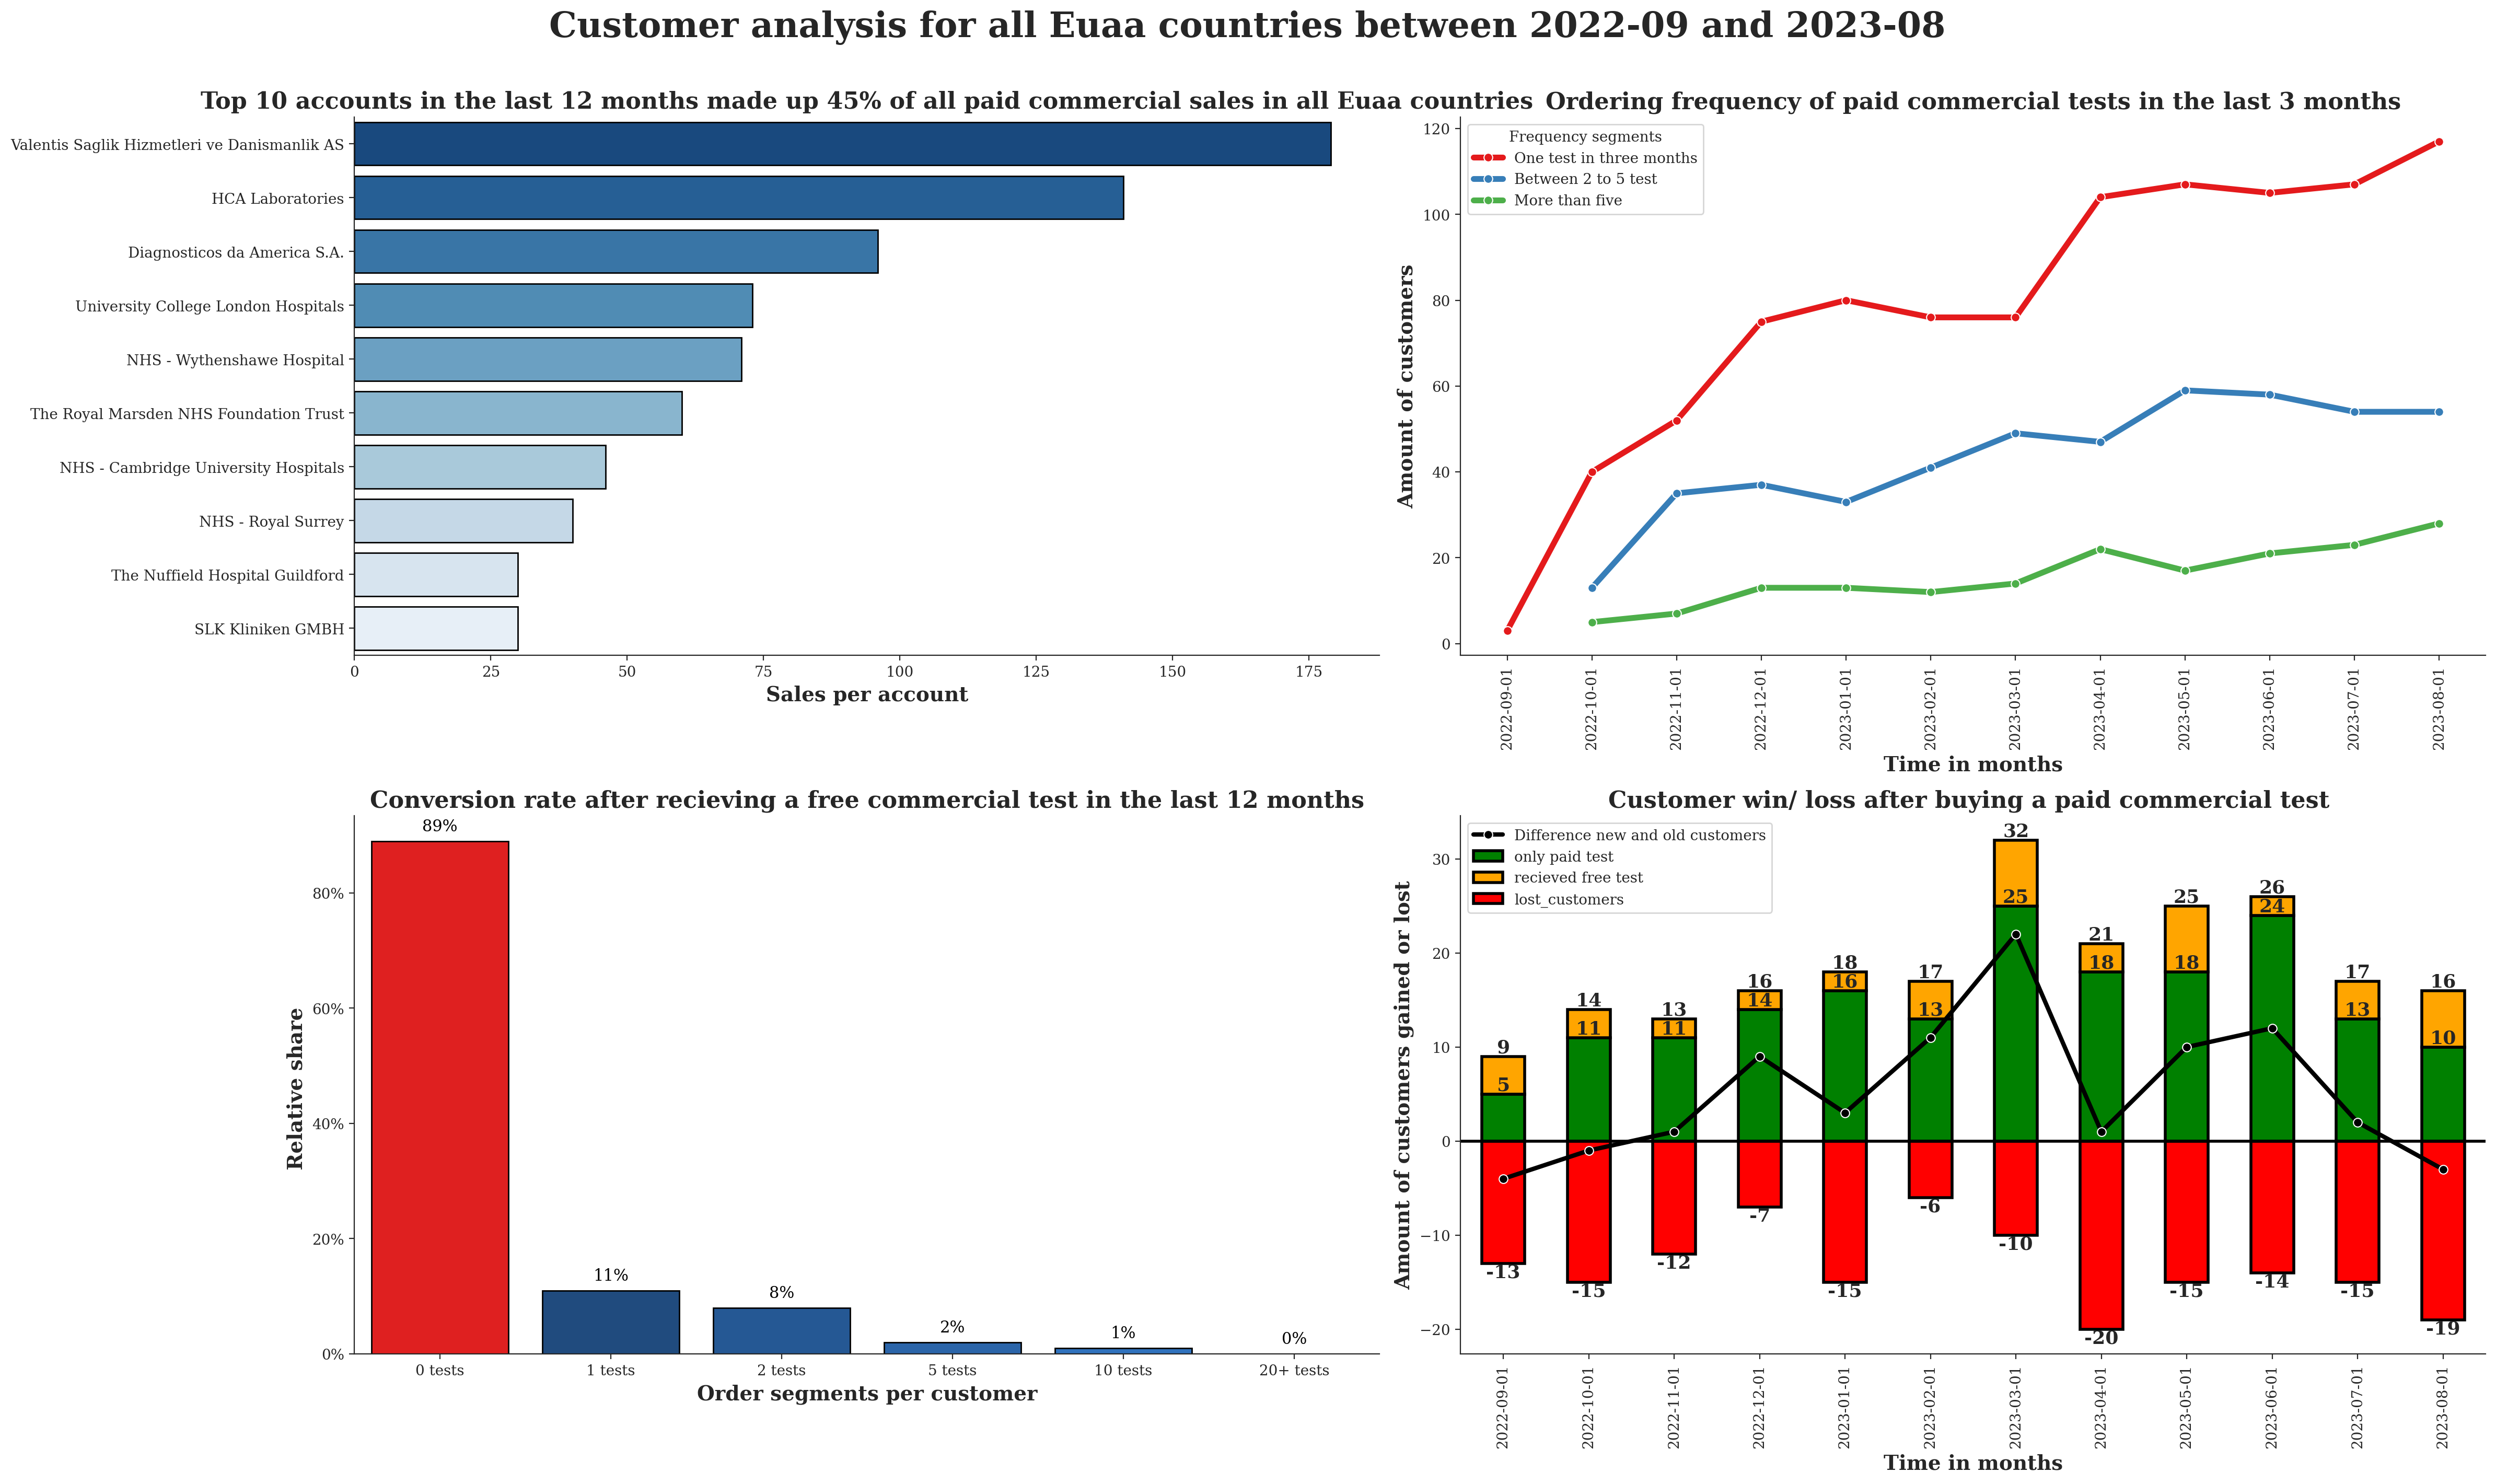

In [109]:
create_all_plots_r(rev_newer,newer_all,countries_list,start_date,end_date)
country_sorters=[]
for coun in countries_list:
    if coun != "all":
      coun=coun.title()
      country_sorters.append(coun)
    else:
      country_sorters.append("all Euaa countries")
countries_sort=country_sorters
os.chdir(Path(dir_path, "finished dashboards"))
for n in countries_sort:
    folder_name= n+"_all_plots"
    os.mkdir(folder_name)
file_sorter(countries_sort)

In [110]:

def ordering_freq_input_new(df,total_df):
    df=df[df["FOC"]=="Paid"].copy()
    total_df=total_df[total_df["FOC"]=="Paid"].copy()
    if len (df)==0:
      elf=pd.DataFrame({"Frequency":[],"Freq_Categories":[],"Date":[]})
      elf=elf.groupby(["Date","Freq_Categories"]).sum()
    else:
      data=pd.DataFrame()
      all_months=df["Year_Month"].unique()

      for month in all_months:
        date_range = pd.date_range(start='2018-01-01', end='2025-12-01', freq='MS').strftime('%Y-%m-%d')
        time_df = pd.DataFrame({"month":date_range})
        single_time_df=time_df["month"][time_df["month"]<=month ].to_list()
        single_time_df=single_time_df[-3:]
        _3_mon_df=total_df[total_df["Year_Month"].isin(single_time_df)]
        Interim_df=_3_mon_df["Contact: Full Name"].value_counts()
        freq_dict = {"Frequency": Interim_df, "Date" : month}
        freq_counts = pd.DataFrame(freq_dict)
        freq_counts["Freq_Categories"] = freq_counts["Frequency"].apply(count_clinician)
        final = freq_counts.groupby(["Date", "Freq_Categories"])["Frequency"].count().reset_index()
        data=data.append(final)

      elf=data.groupby(["Date","Freq_Categories"]).sum()
    return elf

##Euaa volume combined with VHIO and RM

In [111]:
#import vhio and marsden samples
vhio= pd.read_excel("/content/drive/MyDrive/Colab Notebooks/VHIO & RM Monthly Sample & Performance Tracker.xlsx", sheet_name = "VHIO Monthly Samples",skiprows=0)
vhio["Date Received"] = pd.to_datetime(vhio["Date"])
vhio =vhio.set_index("Date Received")
vhio["Sales"]=vhio["Clinical Samples"]
vhio["Sales"].fillna(0,inplace=True)
vhio["Type"]="VHIO"
vhio=vhio[["Sales","Type"]]
rm= pd.read_excel("/content/drive/MyDrive/Colab Notebooks/VHIO & RM Monthly Sample & Performance Tracker.xlsx", sheet_name = "RM Monthly samples",skiprows=0)
rm["Date Received"] = pd.to_datetime(rm["Date"])
rm =rm.set_index("Date Received")
rm["Sales"]=rm["Clinical Sample Volume"]
rm["Sales"].fillna(0,inplace=True)
rm["Type"]="RM"
rm=rm[["Sales","Type"]]
#combine with new df
newer_all_short=newer_all[["Sales","Type"]]
combined_newer = rm.append(vhio)
combined_newer=combined_newer.append(newer_all_short)
#Add  Year Month
combined_newer['Year_Month'] =combined_newer.index.to_period('M')
combined_newer['Year_Month'] =combined_newer['Year_Month'].astype(str)
combined_newer['Year_Month'] = pd.to_datetime(combined_newer['Year_Month'])
# GAP raus
def gap_filter(df,filter):
  if filter=="yes":
    df=df[df["Type"]!="GAP"]
  else:
    pass
  return df

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Colab Notebooks/VHIO & RM Monthly Sample & Performance Tracker.xlsx'

In [ ]:
palette1 = ["#797EF6", "#4ADEDE", "#1AA7EC", "#1E2F97","#808080","#000000"]
def volume_analysis_4_all(df,tot):
    plt.clf()
    sns.set_style({'font.family':'serif', 'font.serif':['Times New Roman']})
    first_date=df.index.astype(str).str[0:7].min()
    last_date=df.index.astype(str).str[0:7].max()
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 12))
#top 2
    rev_plot=df.groupby("Year_Month").sum()
    ef=df.groupby(['Year_Month',"new LIMS Project ID"]).sum()
# bottom 2
    FOC_df=df.groupby(["Year_Month","FOC"]).sum()
    input_data=tot.groupby(["Year_Month","Type"]).sum()
  #00
    sns.set_palette(palette1)
    sns.lineplot(data = input_data, x = "Year_Month", y = "Sales", ax=axs[0, 0],hue="Type", linewidth=4,marker="o")
    axs[0,0].tick_params(axis='x', rotation=90)
    axs[0, 0].set_title("Test volume across all segments", fontsize=16,weight=900, y=1.02)
    axs[0, 0].set_ylabel("Amount of test's sold", fontsize=14,weight=700)
    axs[0, 0].set_xlabel("Time in months", fontsize=14,weight=700)
    axs[0, 0].legend(title='Type')

    sns.set_palette(palette1)
    g=sns.lineplot(data=rev_plot,x="Year_Month", y="Revenue (USD)", ax=axs[0, 1]
             ,linewidth=4,marker="o" )
    axs[0,1].tick_params(axis='x', rotation=90)
    axs[0, 1].set_title('Monthly revenue for commercial cases', fontsize=16,weight=900, y=1.02)
    axs[0, 1].set_ylabel("Revenue per month in $", fontsize=14,weight=700)
    axs[0, 1].set_xlabel("Time in months", fontsize=14,weight=700)
    ylabels = ['{:,.0f}'.format(x)+ '$' for x in g.get_yticks()]
    g.set_yticklabels(ylabels)

    sns.set_palette(palette1)
    sns.lineplot(data = ef, x = 'Year_Month', y = "Product",
                     linewidth=4,hue="new LIMS Project ID", ax=axs[1, 0],marker="o" )
    axs[1,0].tick_params(axis='x', rotation=90)
    axs[1, 0].set_title("Commercial volume per product", fontsize=16,weight=900, y=1.02)
    axs[1, 0].set_ylabel("Amount of test's sold", fontsize=14,weight=700)
    axs[1, 0].set_xlabel("Time in months", fontsize=14,weight=700)
    axs[1, 0].legend(title='Product type')

    sns.set_palette(palette1)
    sns.lineplot(data = FOC_df, x = "Year_Month", y = "Product", hue = "FOC"
                     ,linewidth=4, ax=axs[1, 1],marker="o" )
    axs[1,1].tick_params(axis='x', rotation=90)
    axs[1, 1].set_title("Development of paid and free commercial test's ", fontsize=16,weight=900, y=1.02)
    axs[1, 1].set_ylabel("Amount of test's sold", fontsize=14,weight=700)
    axs[1, 1].set_xlabel("Time in months", fontsize=14,weight=700)
    axs[1, 1].legend(title='Paid or free test')
    fig.suptitle(f"Volume metrics for in EUAA between {first_date} and {last_date}",
    fontsize=24, fontweight='bold', y=1.01)
    plt.tight_layout()
    sns.despine()
    images_dir = '/content/drive/MyDrive/Colab Notebooks/finished dashboards'
    filename=f"regional_dashboard_with RM and VHIO.pdf"
    plt.savefig(f"{images_dir}/{filename}", dpi = 300,pad_inches = 1, bbox_inches ="tight")


# select the data and run it

In [ ]:
start_date = "2022-09-01"
end_date = "2023-08-31"
Gap="yes" # "yes" or"No" if yes GAP will be filtered out, if No it will remain inside
combined_newer_gap=gap_filter(combined_newer,Gap)
combined_newer_intervall=combined_newer_gap.loc[start_date:end_date]
rev_df=rev_newer.loc[start_date:end_date]
volume_analysis_4_all(rev_df,combined_newer_intervall)
